In [3]:
# Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import pickle
import math
import gymnasium as gym
import matplotlib.pyplot as plt

In [4]:
# plot epsilon-decay graph
def show_epsilon_decay(epsilon_array, episodes):
    plt.figure()
    plt.plot(epsilon_array)
    plt.title("Epsilon Decay Graph")
    plt.xlabel("episode")
    plt.ylabel("epsilon value")
    plt.xlim(0,episodes)
    plt.ylim(0,1)
    plt.grid()
    plt.show()

In [5]:
# plot cumulative rewards graph
def total_reward_per_episode(total_reward):
    plt.figure()
    plt.plot(total_reward)
    plt.title('Total Reward per Episode')
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.xlim(0, 10)
    plt.ylim(-20, 100)
    plt.grid()
    plt.show()

In [6]:
# one hot encoding of an integer
def one_hot_encoder(integer_state):
    return tf.one_hot(indices = integer_state, depth = 16, dtype = np.int32)

### _2.1 Implementing DQN & solving Grid-World environment_

In [25]:
# define deterministic grid environment
class DeterministicGridEnvironment:
    
    def __init__(self):
        
        self.observation_space = 16
        
        # define and initialize the environment
        row0 = [0, 1, 2, 5]
        row1 = [1, 2, 7, 10]
        row2 = [-1, 2, 9, 20]
        row3 = [1, 5, 20, 50]
        self.environment = np.reshape(np.vstack((row0,row1, row2, row3)),(4,4))/50
        
        # initial state of the agent
        self.agent_state = (0,0) 
        
    def reset(self):
        
        # define and initialize the environment
        row0 = [0, 1, 2, 5]
        row1 = [1, 2, 7, 10]
        row2 = [-1, 2, 9, 20]
        row3 = [1, 5, 20, 50]
        self.environment = np.reshape(np.vstack((row0,row1, row2, row3)),(4,4))/50
        
        # initial state of the agent
        self.agent_state = (0,0) 
        integer_state = int((self.agent_state[0]*4) + (self.agent_state[1]))
        
        return integer_state
        
    def step(self, action):
        
        terminated = 0
        old_integer_state = int((self.agent_state[0]*4) + (self.agent_state[1]))
        
        current_state = self.agent_state

        if action == 0:  # UP
            current_state = (current_state[0]-1, current_state[1])
        elif action == 1:  # DOWN
            current_state = (current_state[0]+1,current_state[1])
        elif action == 2:  # LEFT
            current_state = (current_state[0],current_state[1]-1)
        elif action == 3: # RIGHT
            current_state = (current_state[0],current_state[1]+1)
            
        current_state = tuple(np.clip(current_state, 0, 3))
        
        if current_state == (3,3):
            terminated = 1
        
        imm_reward = self.environment[current_state[0], current_state[1]]
        
        self.agent_state = current_state
        
        new_integer_state = int((self.agent_state[0]*4) + (self.agent_state[1]))
        
        # step taken by environment returns the immediate reward, agent_state & meta_data
        return old_integer_state, imm_reward, new_integer_state, terminated
    
    def render(self):

        a = "O=o"  # symbol for the agent, a car!
        s = " "
        print("-------------------------------", end="\n")
        for row in range(4):
            for col in range(4):
                if (row, col) == self.agent_state:
                    print(f"|{a:^{5}}|", end=" ")
                else:
                    print(f"|{self.environment[row, col]:^{5}}|", end=" ")
            print("\n-------------------------------", end="\n")

In [26]:
# define DQN agent
class DQN_Agent:
    
    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 4
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.environment = environment
        
        # Initialize and compile the Q-network
        self.policy_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (16,)),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(4)])
        
        self.policy_model.compile(optimizer = "adam",loss = "mean_squared_error")
        
        # Initialize and compile the Target Q-network
        self.target_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (16,)),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(4)])

        self.target_model.compile(optimizer = "adam",loss = "mean_squared_error")
        
        # synchronize weights of both the networks
        self.target_model.set_weights(self.policy_model.get_weights())
        
    def step(self, epsilon, agent_state, training = True):
        
        rand_num = np.random.random()
            # explore
        if  rand_num < epsilon and training:
            return np.random.randint(self.action_space) 
        else:
            # exploit
            one_hot_state = np.reshape(one_hot_encoder(agent_state), (1, -1))
            return np.argmax(self.policy_model.predict(one_hot_state, verbose = 0)) 
        
    def predict_train(self, mini_batch):
        
        q_values = np.zeros((mini_batch.shape[0],self.action_space))

        # find the target Q-value for a given sample by running a forward pass over the target Q-network
        for index, sample in enumerate(mini_batch):
            
            # old_state, action, reward, new_state, terminated 
            if sample[-1]:
                target = sample[2]
            else:
                integer_state = sample[3]
                one_hot_state = np.reshape(one_hot_encoder(integer_state), (1, -1))
                
                next_q = self.target_model.predict(one_hot_state, verbose = 0)
                target = sample[2] + self.learning_rate*(np.max(next_q))
                
            q_values[index, :] = self.policy_model.predict(np.reshape(one_hot_encoder(sample[0]), (1, -1)), verbose = 0)
            q_values[index, int(sample[1])] = target
            
        history = self.policy_model.fit(one_hot_encoder(mini_batch[:,0]), q_values, verbose = 0)
            
        return history

In [27]:
# initialize the grid-world environment
environment = DeterministicGridEnvironment()

# initialize the agent with a specific learning rate and gamma value 
agent = DQN_Agent(environment, learning_rate= 0.10, discount_factor = 0.99)

In [28]:
# set-up
replay_memory = list()
batch_size = 128
agent_state = None
episodes = 1000
max_timesteps = 40
epsilon_decay = [max(1*(0.9955**i),0.01) for i in range(episodes)]
reward_history = list()
optimum_loss = np.inf
no_improvement_count = 0
flag = False

# training
for episode in range(episodes):
    step_count = 0
    agent_state = environment.reset()
    rewards = 0
    
    while step_count <= max_timesteps:
        
        # take a random action with a probability epsilon
        action = agent.step(epsilon_decay[episode], agent_state)
        
        # action executed by the environment
        old_state, reward, new_state, terminated = environment.step(action)
        
        # append sample to the replay memory
        replay_memory.append([old_state, action, reward, new_state, terminated])
        
        rewards += reward
        agent_state = new_state
        step_count +=1
        
        # train the Q-network and fit to target Q-network once in every 10 steps and 
        # only when replay memory has a minimum number of samples
        if step_count%20 == 0 and len(replay_memory) >= batch_size:
            
            mini_batch = np.array(random.sample(replay_memory, batch_size))
            history = agent.predict_train(mini_batch)
            loss = history.history["loss"][0]
            
            # early-stopping
            if loss < optimum_loss:
                optimum_loss  = loss
                no_improvement_count = 0
            else:
                no_improvement_count +=1
            
            if no_improvement_count > 20:
                flag = True
                break
            
            if terminated: break
 
    reward_history.append(rewards)
    
    if flag: break
    
    # synchronize weights of both the networks, once in every 10 episodes
    if episode%10 == 0:
        agent.target_model.set_weights(agent.policy_model.get_weights())

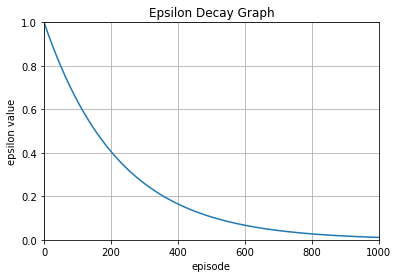

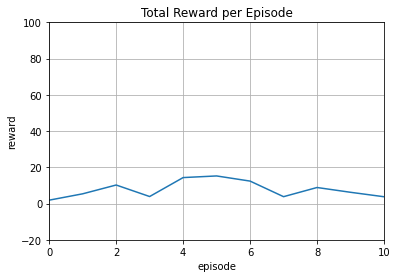

In [31]:
# epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# cummulative reward per episode graph
total_reward_per_episode(reward_history)

selected action: down
-------------------------------
| 0.0 | |0.02 | |0.04 | | 0.1 | 
-------------------------------
| O=o | |0.04 | |0.14 | | 0.2 | 
-------------------------------
|-0.02| |0.04 | |0.18 | | 0.4 | 
-------------------------------
|0.02 | | 0.1 | | 0.4 | | 1.0 | 
-------------------------------
selected action: right
-------------------------------
| 0.0 | |0.02 | |0.04 | | 0.1 | 
-------------------------------
|0.02 | | O=o | |0.14 | | 0.2 | 
-------------------------------
|-0.02| |0.04 | |0.18 | | 0.4 | 
-------------------------------
|0.02 | | 0.1 | | 0.4 | | 1.0 | 
-------------------------------
selected action: right
-------------------------------
| 0.0 | |0.02 | |0.04 | | 0.1 | 
-------------------------------
|0.02 | |0.04 | | O=o | | 0.2 | 
-------------------------------
|-0.02| |0.04 | |0.18 | | 0.4 | 
-------------------------------
|0.02 | | 0.1 | | 0.4 | | 1.0 | 
-------------------------------
selected action: right
-------------------------------
|

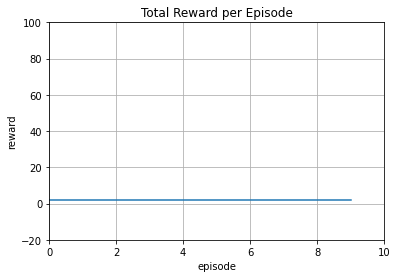

In [32]:
# evaluation
episodes = 10
max_timesteps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
reward_history = list()

for episode in range(episodes):
    step_count = 0
    agent_state = environment.reset()
    rewards = 0
    loss = 0
    
    while step_count < max_timesteps:
        
        action = agent.step(epsilon_decay[episode], agent_state, False)
        print("selected action:", action_map[action])
        
        old_integer_state, reward, new_integer_state, terminated = environment.step(action)
        
        environment.render()
        
        rewards += reward
        agent_state = new_integer_state
        step_count +=1
        
        if terminated: 
            print("episode terminated!")
            print()
            break
            
    reward_history.append(rewards)
        
# cummulative reward per episode graph
total_reward_per_episode(reward_history)

In [33]:
# save the model in .h5 format
agent.policy_model.save("likhitsa_assignment2_part2_dqn_gridworld.h5")

### _2.2 Applying DQN to solve CartPole-V1 environment_

In [5]:
# define DQN agent
class DQN_CartPole_Agent:

    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 2
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.environment = environment

        # Initialize and compile the Policy Q-network
        self.policy_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (4,)),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(8, activation = 'relu'),
            tf.keras.layers.Dense(2)])

        self.policy_model.compile(optimizer = "adam",loss = "mean_squared_error")

        # Initialize and compile the Target Q-network
        self.target_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (4,)),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(8, activation = 'relu'),
            tf.keras.layers.Dense(2)])

        self.target_model.compile(optimizer = "adam",loss = "mean_squared_error")
        
        # synchronize weights of both the networks
        self.target_model.set_weights(self.policy_model.get_weights())
        
    def step(self, epsilon, agent_state, flag = True):
        
        rand_num = np.random.random()
            # explore
        if  rand_num < epsilon and flag:
            return np.random.randint(self.action_space)
        else:
            # exploit
            agent_state = np.reshape(agent_state, (-1,4))
            return np.argmax(self.policy_model.predict(agent_state, verbose = 0))

    def predict_train(self, mini_batch):
        
        st = np.zeros((1,4))
        q_values = np.zeros((mini_batch.shape[0],self.action_space))
        
        # find the target Q-value for a given sample by running a forward pass over the target Q-network
        for index, sample in enumerate(mini_batch):
            # old_state, action, reward, new_state, terminated
            
            st =  np.vstack((st, np.reshape(sample[0],(1,4)))) 
            
            if sample[-1]:
                target = sample[2]
            else:
                state = np.reshape(sample[3], (-1,4))
                
                next_q = self.target_model.predict(state, verbose = 0)
                target = sample[2] + self.learning_rate*(np.max(next_q))
                
            q_values[index, :] = self.policy_model.predict(np.reshape(sample[0], (-1,4)), verbose = 0)
            q_values[index, int(sample[1])] = target
        
        history = self.policy_model.fit(st[1:,:], q_values, verbose = 0)
        
        return history

In [6]:
# initialize the cartpole environment
C_environment = gym.make('CartPole-v1', render_mode = "human")

# initialize the agent with a specific learning rate and gamma value
C_agent = DQN_CartPole_Agent(C_environment, learning_rate= 0.10, discount_factor= 0.99)

2024-04-04 13:43:08.104191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14650 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-04-04 13:43:08.104908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14650 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [7]:
# set-up 
replay_memory = list()
batch_size = 128
history = None
agent_state = None
episodes = 1000
max_timesteps = 50
epsilon_decay = [max(1*(0.9955**i),0.01) for i in range(episodes)]
C_reward_history = []
optimum_loss = np.inf
flag = False

# training
for episode in range(episodes):

    step_count = 0
    agent_state = C_environment.reset()[0]
    rewards = 0

    while step_count <= max_timesteps:

        # take a random action with a probability epsilon
        action = C_agent.step(epsilon_decay[episode], agent_state)

        # action executed by the environment
        new_state, reward, terminated,truncated, info = C_environment.step(action)
        
        # append sample episode to replay memory
        replay_memory.append([agent_state, action, reward, new_state, terminated])

        rewards += reward

        agent_state = new_state
        step_count +=1

        # train the Q-network and fit to target Q-network once in every 10 steps and 
        # only when replay memory has a minimum number of samples
        if step_count%10 == 0 and len(replay_memory) >= batch_size:
            
            # randomly select samples to implement SGD
            mini_batch = np.array(random.sample(replay_memory, batch_size))
            history = C_agent.predict_train(mini_batch)
            loss = history.history["loss"][0]
                        
            # early-stopping
            if loss < optimum_loss:
                optimum_loss  = loss
                no_improvement_count = 0
            else:
                no_improvement_count +=1
            
            if no_improvement_count > 10:
                flag = True
                break
        
        if terminated:
            break

    C_reward_history.append(rewards)

    if flag: break

    # synchronize weights of both the networks, once in every 10 episodes
    if episode%10 == 0:
        C_agent.target_model.set_weights(C_agent.policy_model.get_weights())

libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
/scratch/15437963/ipykernel_3085817/103436039.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(random.sample(replay_memory, batch_size))


NameError: name 'act' is not defined

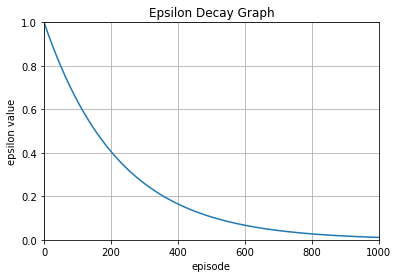

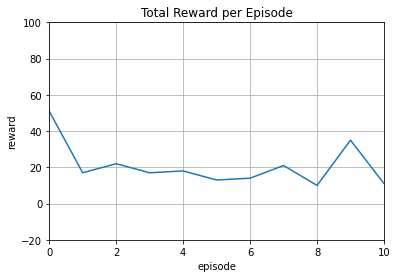

In [41]:
# epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# cummulative reward per episode graph
total_reward_per_episode(C_reward_history)

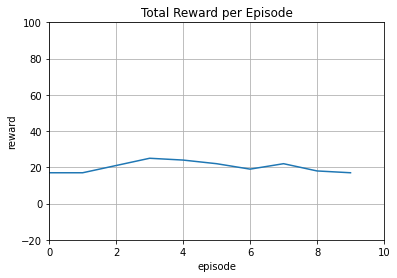

In [42]:
# evaluation
episodes = 10
max_timesteps = 50
C_reward_history = list()

for episode in range(episodes):
    step_count = 0
    agent_state = C_environment.reset()[0]
    rewards = 0
    loss = 0
    
    while step_count <= max_timesteps:
        
        action = C_agent.step(epsilon_decay[episode], agent_state, False)
        
        new_state, reward, terminated, truncated, info = C_environment.step(action)
        
        # environment can be rendered in Tensorflow directly
        C_environment.render()
        
        rewards += reward

        agent_state = new_state
        step_count +=1
        
        if terminated: 
            break

    C_reward_history.append(rewards)
        
# cummulative reward per episode graph
total_reward_per_episode(C_reward_history)

In [43]:
# save the model in .h5 format
C_agent.policy_model.save("likhitsa_assignment2_part2_dqn_cartpole.h5")

### _2.2 Applying DQN to solve Mountain Car environment_ 

In [44]:
# define DQN agent
class DQN_MC_Agent:

    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 3
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.environment = environment

        # Initialize and compile the Q-network
        self.policy_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (2,)),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(3)])

        self.policy_model.compile(optimizer = "adam",loss = "mean_squared_error")

        self.target_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (2,)),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(3)])

        self.target_model.compile(optimizer = "adam",loss = "mean_squared_error")
        
        # synchronize weights of both the networks
        self.target_model.set_weights(self.policy_model.get_weights())

    def step(self, epsilon, agent_state, training = True):

        rand_num = np.random.random()
            # explore
        if  rand_num < epsilon and training:
            return np.random.randint(self.action_space)
        else:
            # exploit
            agent_state = np.reshape(agent_state, (-1,2))
            return np.argmax(self.policy_model.predict(agent_state, verbose = 0))

    def predict_train(self, mini_batch):
        
        st = np.zeros((1,2))
        q_values = np.zeros((mini_batch.shape[0],self.action_space))
        
        # find the target Q-value for a given sample by running a forward pass over the target Q-network
        for index, sample in enumerate(mini_batch):
            
            st =  np.vstack((st, np.reshape(sample[0],(1,2)))) 
            
            if sample[-1]:
                target = sample[2]
            else:
                state = np.reshape(sample[3], (-1,2))
                
                next_q = self.target_model.predict(state, verbose = 0)
                target = sample[2] + self.learning_rate*(np.max(next_q))
                
            q_values[index, :] = self.policy_model.predict(np.reshape(sample[0], (-1,2)), verbose = 0)
            q_values[index, int(sample[1])] = target
        
        history = self.policy_model.fit(act[1:,:], q_values, verbose = 0)
     
        return history

In [45]:
# initialize the Mountain Car environment
MC_environment = gym.make('MountainCar-v0', render_mode = "human")

# initialize the agent with a specific learning rate and gamma value
MC_agent = DQN_MC_Agent(MC_environment, learning_rate= 0.01, discount_factor= 0.99)

In [46]:
# set-up
replay_memory = list()
batch_size = 128
agent_state = None
episodes = 1000
max_timesteps = 200
epsilon_decay = [max(1*(0.9955**i),0.01) for i in range(episodes)]
MC_reward_history = []
optimum_loss = np.inf
no_improvement_count = 0
flag = False

# training
for episode in range(episodes):

    step_count = 0
    agent_state = MC_environment.reset()[0]
    rewards = 0

    while step_count <= max_timesteps:

        # take a random action with a probability epsilon
        action = MC_agent.step(epsilon_decay[episode], agent_state)
        
        # action executed by the environment
        new_state, _, terminated, truncated, info = MC_environment.step(action)
        
        # customised reward function
        agent_state = np.reshape(agent_state, (1,2))
        new_state = np.reshape(new_state, (1, 2))
        reward = 100*((math.sin(3*new_state[0,0]) * 0.0025 + 0.5 * new_state[0,1] * new_state[0,1]) - (math.sin(3*agent_state[0,0]) * 0.0025 + 0.5 * agent_state[0,1] * agent_state[0,1]))

        
        # append sample episode to replay memory
        replay_memory.append([agent_state, action, reward, new_state, terminated])

        rewards += reward

        agent_state = new_state
        step_count +=1

        # train the Q-network and fit to target Q-network once in every 10 steps and 
        # only when replay memory has a minimum number of samples
        if step_count%10 == 0 and len(replay_memory) >= batch_size:
            
            # randomly select samples to implement SGD
            mini_batch = np.array(random.sample(replay_memory, batch_size))
            
            history = MC_agent.predict_train(mini_batch)
            loss = history.history["loss"][0]
            
            # early stopping
            if loss < optimum_loss:
                optimum_loss  = loss
                no_improvement_count = 0
            else:
                no_improvement_count +=1
            
            if no_improvement_count > 20:
                flag = True
                break
        
        if terminated:
            break
        
    MC_reward_history.append(rewards)
    
    if flag:
        break

    # synchronize weights of both the networks, once in every 10 episodes
    if episode%10 == 0:
        MC_agent.target_model.set_weights(MC_agent.policy_model.get_weights())

libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
/scratch/15430396/ipykernel_950709/239868637.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(random.sample(replay_memory, batch_size))


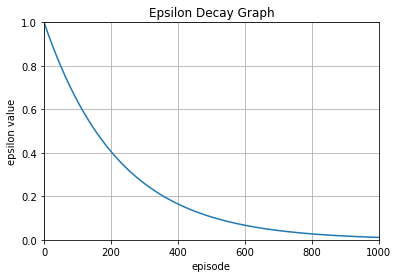

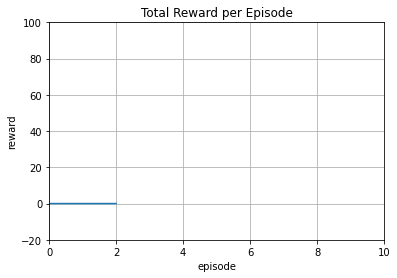

In [47]:
# epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# cummulative reward per episode graph
total_reward_per_episode(MC_reward_history)

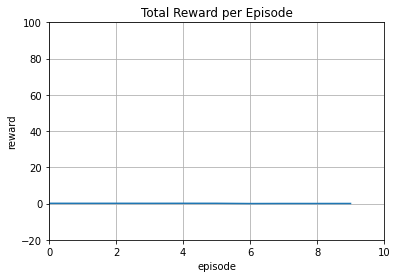

In [48]:
# evaluation
episodes = 10
max_timesteps = 100
MC_reward_history = list()

for episode in range(episodes):
    step_count = 0
    agent_state = MC_environment.reset()[0]
    rewards = 0
    loss = 0

    while step_count < max_timesteps:

        action = MC_agent.step(epsilon_decay[episode], agent_state, False)

        new_state, _, terminated, truncated, info = MC_environment.step(action)
        
        # modified reward function
        reward = 100*((math.sin(3*new_state[0]) * 0.0025 + 0.5 * new_state[1] * new_state[1]) - (math.sin(3*agent_state[0]) * 0.0025 + 0.5 * agent_state[1] * agent_state[1]))

        # environment can be rendered directly in Gooogle Colab
        MC_environment.render()

        rewards += reward

        agent_state = new_state
        step_count +=1
        
        if terminated:
            break

    MC_reward_history.append(rewards)

# cummulative reward per episode graph
total_reward_per_episode(MC_reward_history)

In [49]:
# save the model in .h5 format
MC_agent.policy_model.save("likhitsa_assignment2_part2_dqn_mountaincar.h5")

### _3.1 Improving Vanilla version of DQN - Double DQN Agent in Grid World_

In [13]:
# define Double-DQN agent for grid-world
class DoubleDQN_Agent:
    
    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 4
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.environment = environment
        
        # Initialize and compile the Q-network
        self.policy_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (16,)),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(4)])
        
        self.policy_model.compile(optimizer = "adam",loss = "mean_squared_error")
        
        # implement early stopping for 5 steps
        self.es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, mode='min')
        
        # Initialize and compile the Target Q-network
        self.target_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (16,)),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(4)])

        self.target_model.compile(optimizer = "adam",loss = "mean_squared_error")
        
        # synchronize weights of both the networks
        self.target_model.set_weights(self.policy_model.get_weights())
        
    def step(self, epsilon, agent_state, flag = True):
        
        rand_num = np.random.random()
            # explore
        if  rand_num < epsilon and flag:
            return np.random.randint(self.action_space) 
        else:
            # exploit
            one_hot_state = np.reshape(one_hot_encoder(agent_state), (1, -1))
            return np.argmax(self.policy_model.predict(one_hot_state, verbose = 0)) 
        
    def predict_train(self, mini_batch):
        
        q_values = np.zeros((mini_batch.shape[0],self.action_space))
        
        # find the target Q-value for a given sample by running a forward pass over the target Q-network
        for index, sample in enumerate(mini_batch):
                
            # old_state, action, reward, new_state, terminated 
            if sample[-1]:
                target = sample[2]
            else:
                integer_state = sample[3]
                one_hot_state = np.reshape(one_hot_encoder(integer_state), (1, -1))
                
                output = self.target_model.predict(one_hot_state, verbose = 0)
                ind = np.argmax(self.policy_model.predict(one_hot_state, verbose =  0))
                
                next_q = self.target_model.predict(one_hot_state, verbose = 0)
                target = sample[2] + self.learning_rate*(output[0, ind])
                
            q_values[index, :] = self.policy_model.predict(np.reshape(one_hot_encoder(sample[0]), (1, -1)), verbose = 0)
            q_values[index, int(sample[1])] = target
            
        history = self.policy_model.fit(one_hot_encoder(mini_batch[:,0]), q_values, verbose = 0)
        
        return history

In [14]:
# initialize the grid-world environment
environment = DeterministicGridEnvironment()

# initialize the agent with a specific learning rate and gamma value 
Dagent = DoubleDQN_Agent(environment, learning_rate= 0.10, discount_factor = 0.99)

In [15]:
# set-up
replay_memory = list()
batch_size = 128
agent_state = None
episodes = 1000
max_timesteps = 40
epsilon_decay = [max(1*(0.9955**i),0.01) for i in range(episodes)]
Dreward_history = list()
optimum_loss = np.inf
no_improvement_count = 0
flag = False

# training
for episode in range(episodes):
    step_count = 0
    agent_state = environment.reset()
    rewards = 0
    
    while step_count <= max_timesteps:
        
        # take a random action with a probability epsilon
        action = Dagent.step(epsilon_decay[episode], agent_state)
        
        # action executed by the environment
        old_state, reward, new_state, terminated = environment.step(action)
        
        # append sample to the replay memory
        replay_memory.append([old_state, action, reward, new_state, terminated])
        
        rewards += reward
        agent_state = new_state
        step_count +=1
        
        # train the Q-network and fit to target Q-network once in every 10 steps and 
        # only when replay memory has a minimum number of samples
        if step_count%20 == 0 and len(replay_memory) >= batch_size:
            
            mini_batch = np.array(random.sample(replay_memory, batch_size))
            history = Dagent.predict_train(mini_batch)
            loss = history.history["loss"][0]
            
            # early-stopping
            if loss < optimum_loss:
                optimum_loss  = loss
                no_improvement_count = 0
            else:
                no_improvement_count +=1
            
            if no_improvement_count > 10:
                flag = True
                break
            
            if terminated: break
 
    Dreward_history.append(rewards)
    
    if flag: break
    
    # synchronize weights of both the networks, once in every 10 episodes
    if episode%10 == 0:
        Dagent.target_model.set_weights(Dagent.policy_model.get_weights())

2024-04-03 15:04:29.703500: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x204f4210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 15:04:29.703750: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-04-03 15:04:29.703794: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-04-03 15:04:29.710618: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-03 15:04:29.865011: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


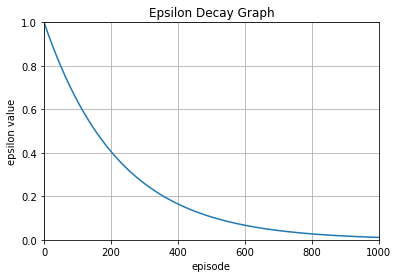

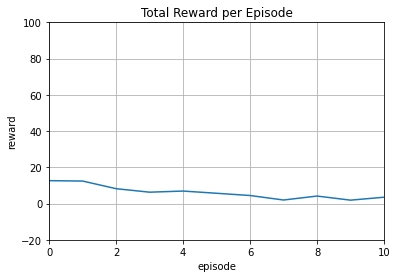

In [16]:
# epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# cummulative reward per episode graph
total_reward_per_episode(Dreward_history)

selected action: right
-------------------------------
| 0.0 | | O=o | |0.04 | | 0.1 | 
-------------------------------
|0.02 | |0.04 | |0.14 | | 0.2 | 
-------------------------------
|-0.02| |0.04 | |0.18 | | 0.4 | 
-------------------------------
|0.02 | | 0.1 | | 0.4 | | 1.0 | 
-------------------------------
selected action: down
-------------------------------
| 0.0 | |0.02 | |0.04 | | 0.1 | 
-------------------------------
|0.02 | | O=o | |0.14 | | 0.2 | 
-------------------------------
|-0.02| |0.04 | |0.18 | | 0.4 | 
-------------------------------
|0.02 | | 0.1 | | 0.4 | | 1.0 | 
-------------------------------
selected action: right
-------------------------------
| 0.0 | |0.02 | |0.04 | | 0.1 | 
-------------------------------
|0.02 | |0.04 | | O=o | | 0.2 | 
-------------------------------
|-0.02| |0.04 | |0.18 | | 0.4 | 
-------------------------------
|0.02 | | 0.1 | | 0.4 | | 1.0 | 
-------------------------------
selected action: right
-------------------------------
|

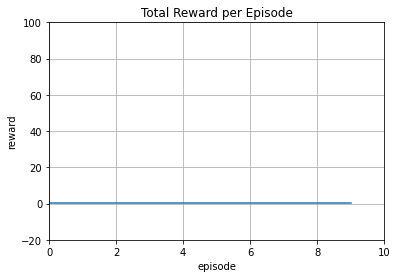

In [17]:
# evaluation
episodes = 10
max_timesteps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
Dreward_history = list()

for episode in range(episodes):
    step_count = 0
    agent_state = environment.reset()
    rewards = 0
    loss = 0
    
    while step_count < max_timesteps:
        
        action = Dagent.step(epsilon_decay[episode], agent_state, False)
        print("selected action:", action_map[action])
        
        old_integer_state, imm_reward, new_integer_state, terminated = environment.step(action)
        
        environment.render()
        
        rewards += reward
        agent_state = new_integer_state
        step_count +=1
        
        if terminated: 
            print("episode terminated!")
            print()
            break
            
    Dreward_history.append(rewards)
        
# cummulative reward per episode graph
total_reward_per_episode(Dreward_history)

In [19]:
# save the model in .h5 format
Dagent.policy_model.save("likhitsa_assignment2_part3_ddqn_gridworld.h5")

### _3.2 Applying Double DQN to solve CartPole Environment_

In [7]:
# define Double-DQN agent CartPole environment
class DoubleDQN_CartPole_Agent:

    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 2
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.environment = environment

        # Initialize and compile the Q-network
        self.policy_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (4,)),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(8, activation = 'relu'),
            tf.keras.layers.Dense(2)])

        self.policy_model.compile(optimizer = "adam",loss = "mean_squared_error")

        # Initialize and compile the Target Q-network
        self.target_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (4,)),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(8, activation = 'relu'),
            tf.keras.layers.Dense(2)])

        self.target_model.compile(optimizer = "adam",loss = "mean_squared_error")
        
        # synchronize weights of both the networks
        self.target_model.set_weights(self.policy_model.get_weights())
        
    def step(self, epsilon, agent_state, flag = True):
        
        rand_num = np.random.random()
            # explore
        if  rand_num < epsilon and flag:
            return np.random.randint(self.action_space)
        else:
            # exploit
            agent_state = np.reshape(agent_state, (-1,4))
            return np.argmax(self.policy_model.predict(agent_state, verbose = 0))

    def predict_train(self, mini_batch):

        st = np.zeros((1,4))
        q_values = np.zeros((mini_batch.shape[0],self.action_space))

        # find the target Q-value for a given sample by running a forward pass over the target Q-network
        for index, sample in enumerate(mini_batch): 
            
            st =  np.vstack((st, np.reshape(sample[0],(1,4))))
            
            if sample[-1]:
                target = sample[2]
            else:
                state = np.reshape(sample[3], (-1,4))
            
                output = self.target_model.predict(state,verbose = 0)
                ind = np.argmax(self.policy_model.predict(state, verbose =  0))
                
                next_q = self.target_model.predict(state, verbose = 0)
                target = sample[2] + self.learning_rate*(output[0,ind])
            
            q_values[index,:] = self.policy_model.predict(np.reshape(sample[0], (-1,4)), verbose = 0)
            q_values[index, int(sample[1])] = target

        # perform gradient descent
        history = self.policy_model.fit(st[1:,:], q_values, verbose  = 0)

        return history

In [8]:
# initialize the cartpole environment
C_environment = gym.make('CartPole-v1', render_mode = "human")

# initialize the agent with a specific learning rate and gamma value
C_Dagent = DoubleDQN_CartPole_Agent(C_environment, learning_rate= 0.10, discount_factor= 0.99)

2024-04-04 14:59:12.479236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14650 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-04-04 14:59:12.480315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14650 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [9]:
# set-up 
replay_memory = list()
batch_size = 128
history = None
agent_state = None
episodes = 1000
max_timesteps = 50
epsilon_decay = [max(1*(0.9955**i),0.01) for i in range(episodes)]
C_Dreward_history = []
optimum_loss = np.inf
flag = False

# training
for episode in range(episodes):

    step_count = 0
    agent_state = C_environment.reset()[0]
    rewards = 0

    while step_count <= max_timesteps:

        # take a random action with a probability epsilon
        action = C_Dagent.step(epsilon_decay[episode], agent_state)

        # action executed by the environment
        new_state, reward, terminated,truncated, info = C_environment.step(action)
        
        # append sample episode to replay memory
        replay_memory.append([agent_state, action, reward, new_state, terminated])

        rewards += reward

        agent_state = new_state
        step_count +=1

        # train the Q-network and fit to target Q-network once in every 10 steps and 
        # only when replay memory has a minimum number of samples
        if step_count%10 == 0 and len(replay_memory) >= batch_size:
            
            # randomly select samples to implement SGD
            mini_batch = np.array(random.sample(replay_memory, batch_size))
            history = C_Dagent.predict_train(mini_batch)
            loss = history.history["loss"][0]
                        
            # early-stopping
            if loss < optimum_loss:
                optimum_loss  = loss
                no_improvement_count = 0
            else:
                no_improvement_count +=1
            
            if no_improvement_count > 10:
                flag = True
                break
        
        if terminated:
            break

    C_Dreward_history.append(rewards)

    if flag: break

    # synchronize weights of both the networks, once in every 10 episodes
    if episode%10 == 0:
        C_Dagent.target_model.set_weights(C_Dagent.policy_model.get_weights())

libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
/scratch/15437963/ipykernel_124648/1418566429.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(random.sample(replay_memory, batch_size))
2024-04-04 14:59:46.316742: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1fc9e8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 14:59:46.316813: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-04-04 14:59:46.316853: I tensorflow/compiler/xla/service/service.cc:1

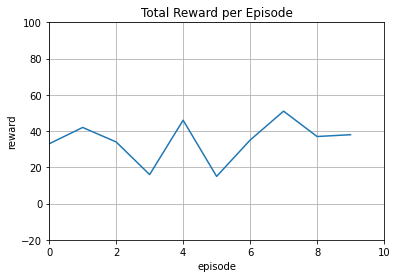

In [10]:
# evaluation
episodes = 10
max_timesteps = 50
C_Dreward_history = list()

for episode in range(episodes):
    step_count = 0
    agent_state = C_environment.reset()[0]
    rewards = 0
    loss = 0
    
    while step_count <= max_timesteps:
        
        action = C_Dagent.step(epsilon_decay[episode], agent_state, False)
        
        new_state, reward, terminated, truncated, info = C_environment.step(action)
        
        # environment can be rendered in Tensorflow directly
        C_environment.render()
        
        rewards += reward

        agent_state = new_state
        step_count +=1
        
        if terminated: 
            break

    C_Dreward_history.append(rewards)
        
# cummulative reward per episode graph
total_reward_per_episode(C_Dreward_history)

In [11]:
# save the model in .h5 format
C_Dagent.policy_model.save("likhitsa_assignment2_part2_ddqn_cartpole.h5")

### _3.2 Applying Double DQN to solve Mountain Car Environment_

In [7]:
# define Double-DQN agent for Mountain Car environment
class DoubleDQN_MC_Agent:

    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 3
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.environment = environment

        # Initialize and compile the Q-network
        self.policy_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (2,)),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(3)])

        self.policy_model.compile(optimizer = "adam",loss = "mean_squared_error")

        self.target_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (2,)),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(3)])

        self.target_model.compile(optimizer = "adam",loss = "mean_squared_error")
        
        # synchronize weights of both the networks
        self.target_model.set_weights(self.policy_model.get_weights())

    def step(self, epsilon, agent_state, training = True):

        rand_num = np.random.random()
            # explore
        if  rand_num < epsilon and training:
            return np.random.randint(self.action_space)
        else:
            # exploit
            agent_state = np.reshape(agent_state, (-1,2))
            return np.argmax(self.policy_model.predict(agent_state, verbose = 0))

    def predict_train(self, mini_batch):

        st = np.zeros((1,2))
        q_values = np.zeros((mini_batch.shape[0],self.action_space))

        # find the target Q-value for a given sample by running a forward pass over the target Q-network
        for index, sample in enumerate(mini_batch):
            
            st =  np.vstack((st, np.reshape(sample[0],(1,2))))

            if sample[-1]:
                target = sample[2]
            else:
                state = np.reshape(sample[3], (-1,2))

                output = self.target_model.predict(state,verbose = 0)
                ind = np.argmax(self.policy_model.predict(state, verbose =  0))

                next_q = self.target_model.predict(state, verbose = 0)
                target = sample[2] + self.learning_rate*(output[0,ind])

            q_values[index,:] = self.policy_model.predict(np.reshape(sample[0], (-1,2)), verbose = 0)
            q_values[index, int(sample[1])] = target

        # perform gradient descent
        history = self.policy_model.fit(st[1:,:], q_values, verbose  = 0)

        return history

In [14]:
# initialize the Mountain Car environment
MC_environment = gym.make('MountainCar-v0', render_mode = "human")

# initialize the agent with a specific learning rate and gamma value
MC_Dagent = DoubleDQN_MC_Agent(MC_environment, learning_rate= 0.01, discount_factor= 0.99)

In [15]:
# set-up
replay_memory = list()
batch_size = 128
agent_state = None
episodes = 500
max_timesteps = 200
epsilon_decay = [max(1*(0.9920**i),0.01) for i in range(episodes)]
MC_Dreward_history = []
optimum_loss = np.inf
no_improvement_count = 0
flag = False

# training
for episode in range(episodes):

    step_count = 0
    agent_state = MC_environment.reset()[0]
    rewards = 0

    while step_count <= max_timesteps:

        # take a random action with a probability epsilon
        action = MC_Dagent.step(epsilon_decay[episode], agent_state)
        
        # action executed by the environment
        new_state, _, terminated, truncated, info = MC_environment.step(action)
        
        # customised reward function
        agent_state = np.reshape(agent_state, (1,2))
        new_state = np.reshape(new_state, (1, 2))
        reward = 100*((math.sin(3*new_state[0,0]) * 0.0025 + 0.5 * new_state[0,1] * new_state[0,1]) - (math.sin(3*agent_state[0,0]) * 0.0025 + 0.5 * agent_state[0,1] * agent_state[0,1]))

        
        # append sample episode to replay memory
        replay_memory.append([agent_state, action, reward, new_state, terminated])

        rewards += reward

        agent_state = new_state
        step_count +=1

        # train the Q-network and fit to target Q-network once in every 10 steps and 
        # only when replay memory has a minimum number of samples
        if step_count%10 == 0 and len(replay_memory) >= batch_size:
            
            # randomly select samples to implement SGD
            mini_batch = np.array(random.sample(replay_memory, batch_size))
            
            history = MC_Dagent.predict_train(mini_batch)
            loss = history.history["loss"][0]
            
            # early stopping
            if loss < optimum_loss:
                optimum_loss  = loss
                no_improvement_count = 0
            else:
                no_improvement_count +=1
            
            if no_improvement_count > 10:
                flag = True
                break
        
        if terminated:
            break
        
    MC_Dreward_history.append(rewards)
    
    if flag:
        break

    # synchronize weights of both the networks, once in every 10 episodes
    if episode%10 == 0:
        MC_Dagent.target_model.set_weights(MC_Dagent.policy_model.get_weights())

libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
/scratch/15430396/ipykernel_1958492/3112874615.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(random.sample(replay_memory, batch_size))
2024-04-03 19:18:37.878219: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x28dccbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 19:18:37.878402: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-04-03 19:18:37.878476: I tensorflow/compiler/xla/service/service.cc:

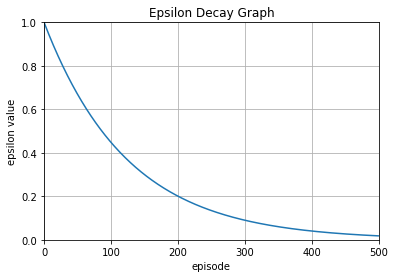

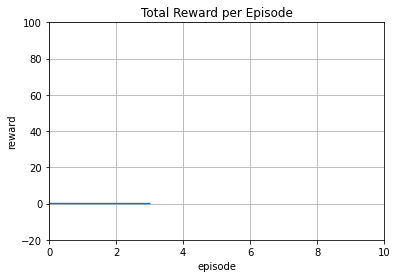

In [16]:
# epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# cummulative reward per episode graph
total_reward_per_episode(MC_Dreward_history)

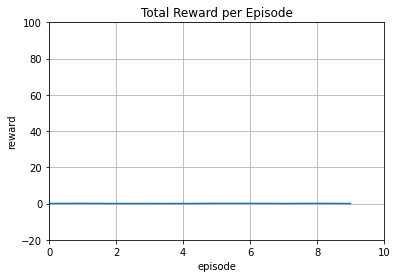

In [17]:
# evaluation
episodes = 10
max_timesteps = 100
MC_Dreward_history = list()

for episode in range(episodes):
    step_count = 0
    agent_state = MC_environment.reset()[0]
    rewards = 0
    loss = 0

    while step_count < max_timesteps:

        action = MC_Dagent.step(epsilon_decay[episode], agent_state, False)

        new_state, _, terminated, truncated, info = MC_environment.step(action)
        
        # modified reward function
        reward = 100*((math.sin(3*new_state[0]) * 0.0025 + 0.5 * new_state[1] * new_state[1]) - (math.sin(3*agent_state[0]) * 0.0025 + 0.5 * agent_state[1] * agent_state[1]))

        # environment can be rendered directly in Gooogle Colab
        MC_environment.render()

        rewards += reward

        agent_state = new_state
        step_count +=1
        
        if terminated:
            break

    MC_Dreward_history.append(rewards)

# cummulative reward per episode graph
total_reward_per_episode(MC_Dreward_history)

In [20]:
# save the model in .h5 format
MC_Dagent.policy_model.save("likhitsa_assignment2_part3_ddqn_mountaincar.h5")

In [41]:
# reward dynamics of grid world -- DQN vs Double DQN

# load the policy_model 
dqn_grid_model = tf.keras.models.load_model('gridworld_model.h5')
ddqn_grid_model = tf.keras.models.load_model('doubleD_gridworld_model.h5')

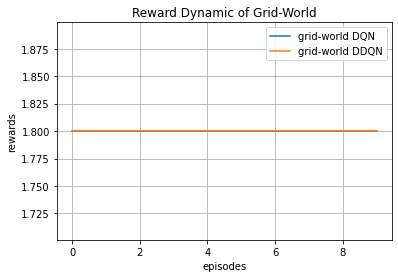

In [42]:
environment = DeterministicGridEnvironment()
episodes = 10
max_timesteps = 30
reward_history1 = list()
reward_history2 = list()

for episode in range(episodes):
    step_count = 0
    agent_state = environment.reset()
    rewards = 0
    
    while step_count < max_timesteps:
        
        one_hot_state = np.reshape(one_hot_encoder(agent_state), (1, -1))
        action =  np.argmax(dqn_grid_model.predict(one_hot_state, verbose = 0))        
        old_integer_state, reward, new_integer_state, terminated = environment.step(action)
        
        rewards += reward
        agent_state = new_integer_state
        step_count +=1
        
        if terminated: break
            
    reward_history1.append(rewards)
        

for episode in range(episodes):
    step_count = 0
    agent_state = environment.reset()
    rewards = 0
    
    while step_count < max_timesteps:
        
        one_hot_state = np.reshape(one_hot_encoder(agent_state), (1, -1))
        action =  np.argmax(ddqn_grid_model.predict(one_hot_state, verbose = 0))        
        old_integer_state, reward, new_integer_state, terminated = environment.step(action)
        
        rewards += reward
        agent_state = new_integer_state
        step_count +=1
        
        if terminated: break
            
    reward_history2.append(rewards)
    
    
    
plt.plot(reward_history1, label = "grid-world DQN")
plt.plot(reward_history2, label = "grid-world DDQN")
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("Reward Dynamic of Grid-World")
plt.legend()
plt.grid()
plt.show()

In [12]:
# reward dynamics of CartPole -- DQN vs Double DQN

# load the policy_model 
dqn_cartpole_model = tf.keras.models.load_model('cartpole_model.h5')
ddqn_cartpole_model = tf.keras.models.load_model('doubleD_cartpole_model.h5')

libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen


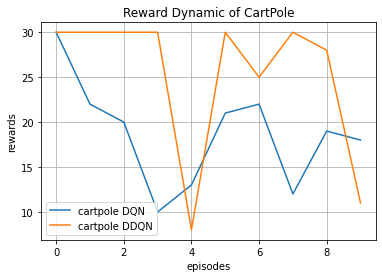

In [13]:
environment = gym.make('CartPole-v1', render_mode = "human")
episodes = 10
max_timesteps = 30
reward_history3 = list()
reward_history4 = list()

for episode in range(episodes):
    step_count = 0
    agent_state = environment.reset()[0]
    rewards = 0
    
    while step_count < max_timesteps:
        
        agent_state = np.reshape(agent_state, (-1,4))
        action =  np.argmax(dqn_cartpole_model.predict(agent_state, verbose = 0))
        new_state, reward, terminated,truncated, info = environment.step(action)
        
        rewards += reward
        agent_state = new_state
        step_count +=1
        
        if terminated: break
            
    reward_history3.append(rewards)
        

for episode in range(episodes):
    step_count = 0
    agent_state = environment.reset()[0]
    rewards = 0
    
    while step_count < max_timesteps:
        
        agent_state = np.reshape(agent_state, (-1,4))
        action =  np.argmax(ddqn_cartpole_model.predict(agent_state, verbose = 0))
        
        new_state, reward, terminated,truncated, info = environment.step(action)
        
        rewards += reward
        agent_state = new_state
        step_count +=1
        
        if terminated: break
            
    reward_history4.append(rewards)
        
plt.plot(reward_history3, label = "cartpole DQN")
plt.plot(reward_history4, label = "cartpole DDQN")
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("Reward Dynamic of CartPole")
plt.legend()
plt.grid()
plt.show()

In [8]:
# reward dynamics of MountainCar -- DQN vs Double DQN

# load the policy_model 
dqn_mountaincar_model = tf.keras.models.load_model('mountaincar_model.h5')
ddqn_mountaincar_model = tf.keras.models.load_model('doubleD_mountiancar_model.h5')

libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen


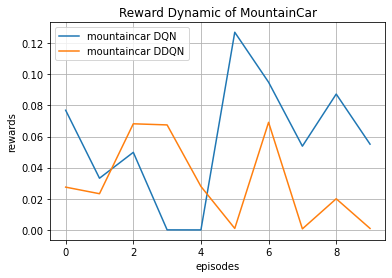

In [9]:
MC_environment = gym.make('MountainCar-v0', render_mode = "human")
episodes = 10
max_timesteps = 80
reward_history5 = list()
reward_history6 = list()

for episode in range(episodes):
    step_count = 0
    agent_state = MC_environment.reset()[0]
    rewards = 0

    while step_count < max_timesteps:

        agent_state = np.reshape(agent_state, (-1,2))
        action = np.argmax(dqn_mountaincar_model.predict(agent_state, verbose = 0))

        new_state, _, terminated, truncated, info = MC_environment.step(action)
        
        # modified reward function
        agent_state = np.reshape(agent_state, (1,2))
        new_state = np.reshape(new_state, (1, 2))
        reward = 100*((math.sin(3*new_state[0,0]) * 0.0025 + 0.5 * new_state[0,1] * new_state[0,1]) - (math.sin(3*agent_state[0,0]) * 0.0025 + 0.5 * agent_state[0,1] * agent_state[0,1]))

        rewards += reward

        agent_state = new_state
        step_count +=1
        
        if terminated: break
            
    reward_history5.append(rewards)

for episode in range(episodes):
    step_count = 0
    agent_state = MC_environment.reset()[0]
    rewards = 0

    while step_count < max_timesteps:

        agent_state = np.reshape(agent_state, (-1,2))
        action = np.argmax(ddqn_mountaincar_model.predict(agent_state, verbose = 0))

        new_state, _, terminated, truncated, info = MC_environment.step(action)
        
        # modified reward function
        agent_state = np.reshape(agent_state, (1,2))
        new_state = np.reshape(new_state, (1, 2))
        reward = 100*((math.sin(3*new_state[0,0]) * 0.0025 + 0.5 * new_state[0,1] * new_state[0,1]) - (math.sin(3*agent_state[0,0]) * 0.0025 + 0.5 * agent_state[0,1] * agent_state[0,1]))

        rewards += reward

        agent_state = new_state
        step_count +=1
        
        if terminated:
            break

    reward_history6.append(rewards)

plt.plot(reward_history5, label = "mountaincar DQN")
plt.plot(reward_history6, label = "mountaincar DDQN")
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("Reward Dynamic of MountainCar")
plt.legend()
plt.grid()
plt.show()